# Pre-process SPC strom reports

In [1]:
import sys
from glob import glob

import h5py
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import preprocess_utils as pu

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import importlib
importlib.reload(du)

<module 'data_utils' from '/glade/u/home/ksha/NCAR/libs/data_utils.py'>

### Domain info

In [5]:
with h5py.File(save_dir+'CONUS_domain.hdf', 'r') as h5io:
    lon = h5io['lon_72km'][...]
    lat = h5io['lat_72km'][...]
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]

### The main pre-processing section

In [6]:
# 4: datetime
# 5: local time
# 6: Timezone
# 15, 16: start lat/lon
preserve_inds = [4, 5, 6, 15, 16]

for y in range(2010, 2021):
    year_int = int(y)
    year = str(year_int)
    # Raw tornado files
    file_torn = sorted(glob(report_dir+'{}_torn.csv'.format(year)))[0]
    # import csv to pandas and then np.array
    df = pd.read_csv(file_torn)
    temp_array = df.iloc[:, preserve_inds].values

    # datetime and timezone processing
    L = len(temp_array)
    temp_tz = temp_array[:, 2]
    temp_dt_list = []
    flag_badboy = False

    for i in range(L):
        try:
            # the string can be converted to datetime object
            temp_localtime = datetime.strptime(temp_array[i, 0]+'|'+temp_array[i, 1], '%Y-%m-%d|%H:%M:%S')
            flag_badboy = False
        except:
            # the string cannot be converted; typically a "?"
            temp_localtime = np.nan
            flag_badboy = True

        # adjust timezones to UTC/GMT 
        if flag_badboy is False:
            temp_tz = temp_array[i, 2]
            if temp_tz == 3:
                temp_localtime = temp_localtime + timedelta(hours=6) # "3" means CST
            elif temp_tz == 9:
                temp_localtime = temp_localtime # "9" means GMT
            else:
                temp_localtime = np.nan # otherwise doint know

        temp_dt_list.append(temp_localtime)

    # Insert in-situ reports into hourly, gridded data frames    
    ## convert slat slon to domain indices
    indx, indy = du.grid_search(lon, lat, temp_array[:, 4], temp_array[:, 3])

    # allocate output
    grid_shape = lon.shape

    if du.is_leap_year(year_int):
        N_days = 366
    else:
        N_days = 365

    N_hours = N_days*24 + 6 # +6 because timezone diff can cross years

    data = np.zeros((N_hours,)+grid_shape)

    date_ref = datetime(year_int, 1, 1, 0, 0)

    ind_positive_hrs_dup = []

    for i in range(L):
        temp_datetime = temp_dt_list[i]
        dt_diff = temp_datetime - date_ref
        hr_diff = int(divmod(dt_diff.total_seconds(), 3600)[0])
        data[hr_diff, indx[i], indy[i]] = 1.0
        ind_positive_hrs_dup.append(hr_diff)

    ind_positive_hrs_dup = np.array(ind_positive_hrs_dup)
    ind_positive_hrs = np.unique(ind_positive_hrs_dup)

    tuple_save = (data, ind_positive_hrs_dup, ind_positive_hrs, indx, indy, lon, lat, lon_3km, lat_3km)
    label_save = ['tornado', 'ind_pos_dup', 'ind_pos', 'indx', 'indy', 'lon_72km', 'lat_72km', 'lon_3km', 'lat_3km']
    du.save_hdf5(tuple_save, label_save, save_dir, 'SPC_{}.hdf'.format(year))

Save to /glade/work/ksha/NCAR/SPC_2010.hdf
Save to /glade/work/ksha/NCAR/SPC_2011.hdf
Save to /glade/work/ksha/NCAR/SPC_2012.hdf
Save to /glade/work/ksha/NCAR/SPC_2013.hdf
Save to /glade/work/ksha/NCAR/SPC_2014.hdf
Save to /glade/work/ksha/NCAR/SPC_2015.hdf
Save to /glade/work/ksha/NCAR/SPC_2016.hdf
Save to /glade/work/ksha/NCAR/SPC_2017.hdf
Save to /glade/work/ksha/NCAR/SPC_2018.hdf
Save to /glade/work/ksha/NCAR/SPC_2019.hdf
Save to /glade/work/ksha/NCAR/SPC_2020.hdf


### Testing file I/O

In [7]:
with h5py.File(save_dir+'SPC_2016.hdf', 'r') as h5io:
    data = h5io['tornado'][...]
    indx = h5io['indx'][...]
    indy = h5io['indy'][...]
    lon = h5io['lon_72km'][...]
    lat = h5io['lat_72km'][...]
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    ind_positive_hrs_dup = h5io['ind_pos_dup'][...]

### Testing the frame selector

Frame selector will be used to select 3-km gridded predictors by accepting the storm report case number as input

In [8]:
# def frame_selector(data, xi, yi, gap_target, N_range_encode):
#     '''
#     Selecting [gap_target*N_range_encode] sized patches from 3-km model run
#     '''
#     assert N_range_encode % 2 == 1
#     N_range_half = (N_range_encode - 1) // 2 # half of the encoded target grids
#     gap_encode_left = gap_target*N_range_half # left side of the encoded target grids converted to model grids
#     gap_encode_right = gap_target*N_range_half+gap_target # right side of the encoded target grids converted to model grids
#     return data[xi*gap_target-gap_encode_left:xi*gap_target+gap_encode_right, yi*gap_target-gap_encode_left:yi*gap_target+gap_encode_right]

In [9]:
case_num = 1

# xi, yi are the nearest negibours of slon, slat on 72-km domain
xi = indx[case_num]
yi = indy[case_num]

print('positive case: {}'.format(data[ind_positive_hrs_dup[1], indx[1], indy[1]]))

positive case: 1.0


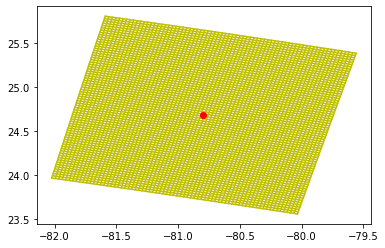

In [10]:
lon_select = pu.frame_selector(lon_3km, xi, yi, gap_target=24, N_range_encode=3)
lat_select = pu.frame_selector(lat_3km, xi, yi, gap_target=24, N_range_encode=3)

plt.plot(lon_select, lat_select, 'y-');
plt.plot(lon_select.T, lat_select.T, 'y-');

plt.plot(lon[xi, yi], lat[xi, yi], 'ro')

^^ Frames are extracted correctly

### Tornado counts climatology

/glade/scratch/ksha/ipykernel_87049/1374982305.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon, lat, np.sum(data, axis=0), vmin=0, vmax=2.0)


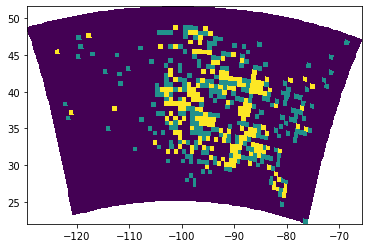

In [11]:
plt.pcolormesh(lon, lat, np.sum(data, axis=0), vmin=0, vmax=2.0)